In [ ]:
!pip install accelerate -U

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install transformers[torch]
#!pip install transformers[torch] - U

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import random

class TextPairDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded_pair = self.tokenizer(
            self.texts[idx][0], self.texts[idx][1],
            truncation=True, padding='max_length', max_length=512,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded_pair.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

df = pd.read_csv('/content/drive/MyDrive/SampleDataCSL_TSRCoPandVSA.csv')


df_y = df[df['Mapped'] == 'Y']


df_n = df[df['Mapped'] == 'N'].sample(n=400, random_state=42)  # random_state is set for reproducibility


df_combined = pd.concat([df_y, df_n]).dropna(subset=['RequirementDesc', 'RequirementDesc.1'])
df_combined.reset_index(drop=True, inplace=True)
df_combined['is_match'] = df_combined['Mapped'].apply(lambda x: 1 if x == 'Y' else 0)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(zip(df_combined['RequirementDesc'], df_combined['RequirementDesc.1'])),
    df_combined['is_match'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = TextPairDataset(train_texts, train_labels)
test_dataset = TextPairDataset(test_texts, test_labels)

# Initialize model and training
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
training_args = TrainingArguments(
    output_dir='./results',            # Directory where the results and checkpoints will be saved
    num_train_epochs=5,                # Total number of training epochs
    per_device_train_batch_size=32,    # Batch size per device
    warmup_steps=250,                  # Number of warmup steps
    weight_decay=0.01,                 # Weight decay
    logging_dir='./logs',              # Directory for storing logs
    evaluation_strategy="steps",       # Evaluate every `logging_steps`
    save_strategy="steps",             # Save the model every `save_steps`
    save_steps=100,                    # Save the model every 100 steps
    logging_steps=50,                  # Log metrics every 50 steps
    load_best_model_at_end=True        # Load the best model at the end of training
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()
final_results = trainer.evaluate(test_dataset)
print("Test Set Accuracy:", final_results['eval_accuracy'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import random

class TextPairDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Concatenate the group headers with the requirement descriptions
        text_pair_1 = self.texts[idx][0] + " [SEP] " + self.texts[idx][2]  # R_RequirementDesc + R_ReqGroupHeader
        text_pair_2 = self.texts[idx][1] + " [SEP] " + self.texts[idx][3]  # L_RequirementDesc + L_ReqGroupHeader
        encoded_pair = self.tokenizer(
            text_pair_1, text_pair_2,
            truncation=True, padding='max_length', max_length=512,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded_pair.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

df = pd.read_csv('/content/drive/MyDrive/SampleDataCSL_TSRCoPandVSA.csv')


df_y = df[df['Mapped'] == 'Y']


df_n = df[df['Mapped'] == 'N'].sample(n=400, random_state=42)  # random_state is set for reproducibility


df_combined = pd.concat([df_y, df_n]).dropna(subset=['RequirementDesc', 'RequirementDesc.1', 'L_ReqGroupHeader', 'R_ReqGroupHeader'])
df_combined.reset_index(drop=True, inplace=True)
df_combined['is_match'] = df_combined['Mapped'].apply(lambda x: 1 if x == 'Y' else 0)

# Prepare text pairs, including group headers
train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(zip(df_combined['RequirementDesc'], df_combined['RequirementDesc.1'], df_combined['R_ReqGroupHeader'], df_combined['L_ReqGroupHeader'])),
    df_combined['is_match'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = TextPairDataset(train_texts, train_labels)
test_dataset = TextPairDataset(test_texts, test_labels)

# Initialize model and training
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
training_args = TrainingArguments(
    output_dir='./results',            # Directory where the results and checkpoints will be saved
    num_train_epochs=5,                # Total number of training epochs
    per_device_train_batch_size=32,    # Batch size per device
    warmup_steps=250,                  # Number of warmup steps
    weight_decay=0.01,                 # Weight decay
    logging_dir='./logs',              # Directory for storing logs
    evaluation_strategy="steps",       # Evaluate every `logging_steps`
    save_strategy="steps",             # Save the model every `save_steps`
    save_steps=100,                    # Save the model every 100 steps
    logging_steps=50,                  # Log metrics every 50 steps
    load_best_model_at_end=True        # Load the best model at the end of training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
final_results = trainer.evaluate(test_dataset)
print("Test Set Accuracy:", final_results['eval_accuracy'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.683100,0.513730,0.757962
100,0.367000,0.295651,0.891720


Test Set Accuracy: 0.89171974522293


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Load new dataset
new_data_path = '/content/drive/MyDrive/DataSet_2024_07_20.csv'  # Update this path to your new data file
new_df = pd.read_csv(new_data_path)

# Filter and sample the data
df_y = new_df[new_df['Mapped'] == 'Y']
df_n = new_df[new_df['Mapped'] == 'N'].sample(n=1000, random_state=42)  # Sample 1000 'N' Mapped entries

# Combine and prepare the data
df_combined = pd.concat([df_y, df_n]).reset_index(drop=True)
df_combined['is_match'] = df_combined['Mapped'].apply(lambda x: 1 if x == 'Y' else 0)

# Splitting the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(zip(df_combined['L_RequirementDesc'], df_combined['R_RequirementDesc'], df_combined['R_ReqGroupHeader'], df_combined['L_ReqGroupHeader'])),
    df_combined['is_match'].tolist(),
    test_size=0.2,  # 20% test data
    random_state=42
)

# Load the saved model
model_path = '/content/results/checkpoint-100'
model = BertForSequenceClassification.from_pretrained(model_path)

# Dataset class
class TextPairDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_pair_1 = self.texts[idx][0] + " [SEP] " + self.texts[idx][2]
        text_pair_2 = self.texts[idx][1] + " [SEP] " + self.texts[idx][3]
        encoded_pair = self.tokenizer(
            text_pair_1, text_pair_2,
            truncation=True, padding='max_length', max_length=512,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded_pair.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextPairDataset(train_texts, train_labels)
test_dataset = TextPairDataset(test_texts, test_labels)

# Update training arguments
training_args = TrainingArguments(
    output_dir='./new_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./new_logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10
)

# Define compute_metrics function to evaluate the model
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()
final_results = trainer.evaluate(test_dataset)
print("Test Set Accuracy:", final_results['eval_accuracy'])


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.387800,0.355136,0.875598
2,0.204100,0.320648,0.899522
3,0.191300,0.308463,0.923445


Test Set Accuracy: 0.9234449760765551


In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F


model_path = '/content/results/checkpoint-100'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.read_csv('/content/drive/MyDrive/SampleDataCSL_TSRCoPandVSA.csv')
df['RequirementDesc'] = df['RequirementDesc'].apply(lambda x: x.lower().strip())
df['RequirementDesc.1'] = df['RequirementDesc.1'].apply(lambda x: x.lower().strip())

texts = list(zip(df['RequirementDesc'], df['RequirementDesc.1']))
labels = df['Mapped'].apply(lambda x: 1 if x != 'N' else 0).tolist()


encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Create a TensorDataset and DataLoader
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_mask, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model.eval()

all_predictions = []
similarity_scores = []

# Run inference
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, _ = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits


        probs = F.softmax(logits, dim=1)


        match_probabilities = probs[:, 1]  # Assuming class '1' is the match class
        similarity_scores.extend(match_probabilities.tolist())

        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.cpu().numpy())


df['IsCorrectMapping'] = ['Yes' if pred == 1 else 'No' for pred in all_predictions]

df['SimilarityScores'] = similarity_scores


best_alternative_match = []
for i, (mapping, desc1) in enumerate(zip(df['IsCorrectMapping'], df['RequirementDesc.1'])):
    if mapping == 'No':
        max_index = df[(df['IsCorrectMapping'] == 'No') & (df.index != i)]['SimilarityScores'].idxmax()
        best_alternative_match.append(df.loc[max_index, 'RequirementDesc.1'])
    else:
        best_alternative_match.append(desc1)

df['BestMatch_RequirementDesc'] = best_alternative_match

df.to_csv('/content/sample_data/Model_SampleDataCSL_TSRCoPandVSA(SimSco).csv', index=False)
print("DataFrame saved")


DataFrame saved


In [ ]:
import pandas as pd


df = pd.read_csv('/content/sample_data/Model_SampleDataCSL_TSRCoPandVSA(SimSco).csv')

filtered_df = df[df['Mapped'] == 'Y']

accuracy = (filtered_df['IsCorrectMapping'] == 'Yes').mean()

print(f"Accuracy: {accuracy:.2%}")


Accuracy: 70.13%


In [ ]:
import pandas as pd


df = pd.read_csv('/content/sample_data/Model_SampleDataCSL_TSRCoPandVSA(384+400).csv')

filtered_df = df[df['Mapped'] == 'N']

accuracy = (filtered_df['IsCorrectMapping'] == 'No').mean()

print(f"Accuracy: {accuracy:.2%}")


Accuracy: 79.53%


In [ ]:
import pandas as pd

df = pd.read_csv('/content/sample_data/Model_SampleDataCSL_TSRCoPandVSA(384+400).csv')

TP = ((df['Mapped'] == 'Y') & (df['IsCorrectMapping'] == 'Yes')).sum()

TN = ((df['Mapped'] == 'N') & (df['IsCorrectMapping'] == 'No')).sum()

total = len(df)

accuracy = (TP + TN) / total

print(f"Accuracy: {accuracy:.2%}")


Accuracy: 79.36%


**On NEW DATA with THRESHOLD**

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F


model_path = '/content/results/checkpoint-100'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


df = pd.read_csv('/content/drive/MyDrive/TestData_Withoutlabels.csv')  # Update the file path as necessary
df['R_RequirementDesc'] = df['R_RequirementDesc'].apply(lambda x: x.lower().strip())
df['L_RequirementDesc'] = df['L_RequirementDesc'].apply(lambda x: x.lower().strip())

texts = list(zip(df['R_RequirementDesc'], df['L_RequirementDesc']))


encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']


dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model.eval()
similarity_scores = []

with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = F.softmax(logits, dim=1)

        match_probabilities = probs[:, 1]
        similarity_scores.extend(match_probabilities.tolist())


threshold = 0.5
df['Mapped'] = ['Y' if score > threshold else 'N' for score in similarity_scores]

df['SimilarityScores'] = similarity_scores

df.to_csv('/content/sample_data/Processed_NewDataset.csv', index=False)
print("DataFrame saved with Mapped and SimilarityScores columns.")


**On NEW DATA without THRESHOLD**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

# Ensure CUDA operations are visible during debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Setting up the device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and tokenizer
model_path = '/content/new_results/checkpoint-315'
model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load and preprocess the dataset
df = pd.read_csv('/content/drive/MyDrive/TestDataNoLabels_2024_07_20.csv')
df['R_RequirementDesc'] = df['R_RequirementDesc'].apply(lambda x: x.lower().strip())
df['L_RequirementDesc'] = df['L_RequirementDesc'].apply(lambda x: x.lower().strip())

# Prepare text pairs
texts = list(zip(df['R_RequirementDesc'], df['L_RequirementDesc']))

# Encode the text pairs
encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

# Create a TensorDataset and DataLoader
dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)  # Efficient for moving to GPU later

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and similarity scores
similarity_scores = []
all_predictions = []

# Run inference
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)  # Move to GPU here
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        match_probabilities = probs[:, 1]  # Assuming class '1' is the match class
        similarity_scores.extend(match_probabilities.cpu().tolist())

        # Collect all predictions from the batch
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Store results in DataFrame
df['Mapped'] = ['Y' if pred == 1 else 'N' for pred in all_predictions]
df['SimilarityScores'] = similarity_scores

# Save the DataFrame to a new CSV file
df.to_csv('/content/sample_data/Processed_TestDataNoLabels_2024_07_20.csv', index=False)
print("DataFrame saved with 'Mapped' and 'SimilarityScores' columns.")


<ipython-input-5-0dad8bdeeccd>:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/TestDataNoLabels_2024_07_20.csv')


DataFrame saved with 'Mapped' and 'SimilarityScores' columns.


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/sample_data/Processed_TestDataNoLabels_2024_07_20.csv'
df = pd.read_csv(file_path)

# Create a new column 'ThresholdMapping' based on the similarity score threshold of 0.3
df['ThresholdMapping'] = df['SimilarityScores'].apply(lambda x: 'Y' if x > 0.2 else 'N')

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

print("DataFrame updated and saved with a new 'ThresholdMapping' column.")


<ipython-input-7-0f3f7d3933b7>:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


DataFrame updated and saved with a new 'ThresholdMapping' column.


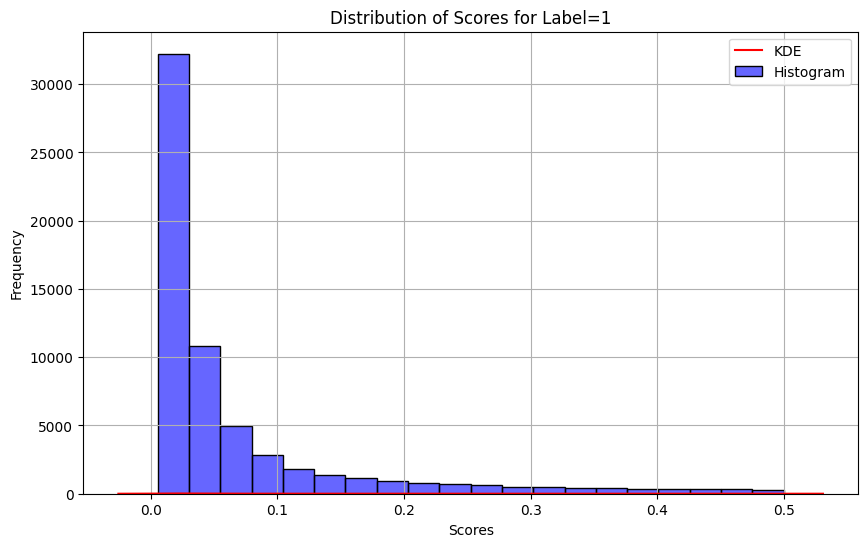

In [ ]:
filtered_df = df[df['Mapped'] == 'N']
filtered_df
import seaborn as sns
import matplotlib.pyplot as plt
# Plot histogram and KDE
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(filtered_df['SimilarityScores'], bins=20, kde=False, color='blue', alpha=0.6, label='Histogram')

# KDE Plot
sns.kdeplot(filtered_df['SimilarityScores'], color='red', label='KDE')

# Labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores for Label=1')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/sample_data/Processed_NewDataset(no_threshold).csv'
data = pd.read_csv(file_path)

# Count 'Y' and 'N' in the 'Mapped' column
count_Y = data['ThresholdMapping'].value_counts().get('Y', 0)
count_N = data['ThresholdMapping'].value_counts().get('N', 0)

# Find the lowest similarity score for 'Y'
lowest_similarity_Y = data[data['Mapped'] == 'Y']['SimilarityScores'].min()
Highest_similarity_N = data[data['Mapped'] == 'N']['SimilarityScores'].max()

# Find the highest and lowest similarity scores overall
highest_similarity = data['SimilarityScores'].max()
lowest_similarity = data['SimilarityScores'].min()

print(f"Count of 'Y': {count_Y}")
print(f"Count of 'N': {count_N}")
print(f"Lowest similarity score for 'Y': {lowest_similarity_Y}")
print(f"Highest similarity score for 'N': {Highest_similarity_N}")
print(f"Highest similarity score overall: {highest_similarity}")
print(f"Lowest similarity score overall: {lowest_similarity}")


Count of 'Y': 14176
Count of 'N': 21874
Lowest similarity score for 'Y': 0.5004828572273254
Highest similarity score for 'N': 0.4998059868812561
Highest similarity score overall: 0.7597250938415527
Lowest similarity score overall: 0.0517330691218376


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import random

class TextPairDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Concatenate the group headers with the requirement descriptions
        text_pair_1 = self.texts[idx][0] + " [SEP] " + self.texts[idx][2]  # R_RequirementDesc + R_ReqGroupHeader
        text_pair_2 = self.texts[idx][1] + " [SEP] " + self.texts[idx][3]  # L_RequirementDesc + L_ReqGroupHeader
        encoded_pair = self.tokenizer(
            text_pair_1, text_pair_2,
            truncation=True, padding='max_length', max_length=512,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded_pair.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

df = pd.read_csv('/content/drive/MyDrive/SampleDataCSL_TSRCoPandVSA.csv')


df_y = df[df['Mapped'] == 'Y']


df_n = df[df['Mapped'] == 'N'].sample(n=400, random_state=42)  # random_state is set for reproducibility


df_combined = pd.concat([df_y, df_n]).dropna(subset=['L_RequirementDesc', 'R_RequirementDesc', 'L_ReqGroupHeader', 'R_ReqGroupHeader'])
df_combined.reset_index(drop=True, inplace=True)
df_combined['is_match'] = df_combined['Mapped'].apply(lambda x: 1 if x == 'Y' else 0)

# Prepare text pairs, including group headers
train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(zip(df_combined['L_RequirementDesc'], df_combined['R_RequirementDesc'], df_combined['R_ReqGroupHeader'], df_combined['L_ReqGroupHeader'])),
    df_combined['is_match'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = TextPairDataset(train_texts, train_labels)
test_dataset = TextPairDataset(test_texts, test_labels)

# Initialize model and training
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
training_args = TrainingArguments(
    output_dir='./results',            # Directory where the results and checkpoints will be saved
    num_train_epochs=3,                # Total number of training epochs
    per_device_train_batch_size=32,    # Batch size per device
    warmup_steps=250,                  # Number of warmup steps
    weight_decay=0.01,                 # Weight decay
    logging_dir='./logs',              # Directory for storing logs
    evaluation_strategy="steps",       # Evaluate every `logging_steps`
    save_strategy="steps",             # Save the model every `save_steps`
    save_steps=100,                    # Save the model every 100 steps
    logging_steps=50,                  # Log metrics every 50 steps
    load_best_model_at_end=True        # Load the best model at the end of training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
final_results = trainer.evaluate(test_dataset)
print("Test Set Accuracy:", final_results['eval_accuracy'])


In [1]:
import pandas as pd
import re
from collections import Counter

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/DataSet_2024_07_20.csv')

# Function to count special characters in a column
def count_special_characters(data_column):
    # Combine all text entries into one large string
    combined_text = ''.join(data_column.dropna())

    # Regular expression to find non-alphanumeric characters
    special_chars = re.findall(r'[^a-zA-Z0-9\s]', combined_text)

    # Count occurrences of each special character
    count = Counter(special_chars)

    return count

# Count special characters in 'L_RequirementDesc' and 'R_RequirementDesc'
special_chars_L = count_special_characters(df['L_RequirementDesc'])
special_chars_R = count_special_characters(df['R_RequirementDesc'])

# Print the counts
print("Special Characters in 'L_RequirementDesc':")
for char, cnt in special_chars_L.items():
    print(f"{char}: {cnt}")

print("\nSpecial Characters in 'R_RequirementDesc':")
for char, cnt in special_chars_R.items():
    print(f"{char}: {cnt}")


Special Characters in 'L_RequirementDesc':
,: 109057
.: 132777
/: 10646
-: 32340
(: 28572
): 35824
;: 11324
+: 1256
': 3528
&: 1598
’: 9929
!: 1284
": 2512
:: 9955
*: 625
“: 933
”: 933
‘: 576
_: 314
•: 16328
{: 628
}: 628
?: 314
%: 314
$: 314
#: 314
<: 314
=: 314
: 314

Special Characters in 'R_RequirementDesc':
.: 132777
,: 109057
): 35824
-: 32340
(: 28572
;: 11324
:: 9955
•: 16328
+: 1256
": 2512
/: 10646
': 3528
’: 9929
“: 933
”: 933
{: 628
}: 628
?: 314
!: 1284
%: 314
$: 314
#: 314
_: 314
*: 625
‘: 576
&: 1598
: 314
<: 314
=: 314


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/DataSet_2024_07_20.csv')

# Define the special characters we're interested in
special_chars = r'[?%$#<=]'

# Function to filter and print statements containing specific special characters
def print_statements_with_special_chars(df, columns, special_chars, num_examples=5):
    # Iterate over the specified columns
    for column in columns:
        print(f"Examples from '{column}' containing special characters {special_chars}:")

        # Filter the DataFrame for entries containing any of the special characters
        filtered = df[df[column].str.contains(special_chars, regex=True, na=False)]

        # Print a few example statements
        for entry in filtered[column].head(num_examples):
            print(entry)
        print("\n")

# Specify columns to search
columns_to_search = ['L_RequirementDesc', 'R_RequirementDesc']

# Call the function
print_statements_with_special_chars(df, columns_to_search, special_chars)


Examples from 'L_RequirementDesc' containing special characters [?%$#<=]:
The element must be able to use passwords of at least 32 characters made up of upper case letters, lower case letters, numbers, and special characters such as {comma},?, !, %, $, #, etc. The {comma} must be supported. Further, it must support the ability to set a password length minimum
The vendor must report all newly-discovered security vulnerabilities in this product to Verizon (<=30 days)
The element must be able to use passwords of at least 32 characters made up of upper case letters, lower case letters, numbers, and special characters such as {comma},?, !, %, $, #, etc. The {comma} must be supported. Further, it must support the ability to set a password length minimum
The element must be able to use passwords of at least 32 characters made up of upper case letters, lower case letters, numbers, and special characters such as {comma},?, !, %, $, #, etc. The {comma} must be supported. Further, it must support

In [4]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/DataSet_2024_07_20.csv')

# Define the list of specific special characters to look for
special_chars = r'[?%$#<=]'

# Function to count entries containing any of the special characters
def count_entries_with_specials(data_column):
    # Drop NA to avoid errors with regex
    valid_entries = data_column.dropna()

    # Count entries that contain any of the special characters
    count = valid_entries.str.contains(special_chars).sum()

    return count

# Count entries in 'L_RequirementDesc' and 'R_RequirementDesc'
count_L = count_entries_with_specials(df['L_RequirementDesc'])
count_R = count_entries_with_specials(df['R_RequirementDesc'])

# Print the results
print(f"Entries with special characters in 'L_RequirementDesc': {count_L}")
print(f"Entries with special characters in 'R_RequirementDesc': {count_R}")


Entries with special characters in 'L_RequirementDesc': 628
Entries with special characters in 'R_RequirementDesc': 628


In [2]:
import pandas as pd
import re

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/DataSet_2024_07_20.csv')

# Function to print sentences with HTML tags or starting with specific patterns
def print_special_sentences(data_column):
    # Regular expression for HTML tags
    html_pattern = re.compile(r'<[^>]+>')
    # Regular expression for sentences starting with 'c)' or 'g)' etc.
    start_pattern = re.compile(r'\b[cghij]\)')

    # Iterate over each entry in the data column
    for text in data_column.dropna():
        # Find sentences using split, regex can be used here as well for more complex sentence detection
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

        for sentence in sentences:
            # Check if the sentence contains HTML tags
            if html_pattern.search(sentence):
                print("HTML Tag in sentence:", sentence)

            # Check if the sentence starts with specific patterns like 'c)' or 'g)'
            #if start_pattern.match(sentence.strip()):
                #print("Starts with specific pattern:", sentence)

# Apply function to 'L_RequirementDesc' and 'R_RequirementDesc'
print("Checking 'L_RequirementDesc' column:")
print_special_sentences(df['L_RequirementDesc'])

print("\nChecking 'R_RequirementDesc' column:")
print_special_sentences(df['R_RequirementDesc'])


Checking 'L_RequirementDesc' column:

Checking 'R_RequirementDesc' column:
